# Problem Statement - I

*******************************************

    ** Build a model that predicts **household income** based on a subset of the features available in the 
    file ‘DEMO_I.csv’.  Consider the typical steps involved in predictive modeling:  
        1. Data Preparation and Exploration
        2. Feature Engineering 
        3. Model Development and Validation
        4. Model Interpretation.  
    Consider the fact that the income provided is Household Income though the records are at the **individual person level**.  
    Clearly present the quality of the model.
    You can choose the algorithm(s) and evaluation metric(s) as you deem appropriate.

    1. ** Data Preparation **
        a. Null Check
        b. Zero Variance Check
        c. Duplicate Check
        d. Quasi Variance Check
        
    2. ** EDA **
        a. Observation basic Uni-variate analysis , Corr and predictive power analysis
        
    3. ** Feature Engineering **
        a. Basic Feature Transformation 
        b. 3-degree Polynomial Transformation
        c. Feature selection based on general understanding
        
    4. ** Model Development & Validation **
        a. LR
        b. Random Forest
        b. LGBM
    5.  Hyper Parameter tuning and Final model
    
    6. ** Model Interpretation
        a. Feature Importance
        
        
    I have approached this problem as part predicing household levle at individual data level as given in dataset.

# Import Libraries 

******************************

## General

In [1]:
import os
import glob
import time
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.cm as cm
import dask.dataframe as dd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D

random.seed(1001)

## Model & Preprocessing Libraries

In [2]:
import gc
import shap
import ppscore as pps
import lightgbm as lgb
import missingno as msno
from sklearn import metrics
from hyperopt import Trials,hp, tpe
from hyperopt.fmin import fmin
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, cross_validate

## Display Settings 

In [3]:
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 999)
pd.set_option('display.max_columns', 999)
pd.set_option("display.max_rows", 999)

## Custom Functions

In [4]:
##Function for Zero/Near-Zero Variance Check and Filter
def zero_variance_extraction(input_df,threshold_n=0.95):
    sel = VarianceThreshold(threshold=(threshold_n* (1 - threshold_n) ))
    sel_var=sel.fit_transform(input_df.fillna(-999))
    return sel.get_support(indices=True)


#Chcek Duplicate Column
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
 
    return list(duplicateColumnNames)

## categorical_summarized (Stolen from Internet)
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    
    print("***************\n Feature Names \n***************\n ")
    print("Target Feature : ", y)
    print("Independent Feature : ", hue)
    
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
#     print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
#         print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

# Intial analysis and Data Prep.

*********************************************

In [5]:
demo_df = pd.read_csv("DEMO_I.csv")

In [6]:
demo_df = demo_df.infer_objects() 
print("Varibale types and count:\n******************************\n", 
      pd.DataFrame(demo_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"}))

Varibale types and count:
******************************
   variableType  count
0      float64     47


In [7]:
print("*************************************************")
print("demo_df shape: #rows, #columns :-",demo_df.shape)
print("*************************************************")
print("Data info:\n")
print("*************************************************")
print(demo_df.info())
print("*************************************************")
print("Glimpse of data:\n")
print("*************************************************")
print(demo_df.head(3).transpose())

*************************************************
demo_df shape: #rows, #columns :- (9971, 47)
*************************************************
Data info:

*************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9971 entries, 0 to 9970
Data columns (total 47 columns):
SEQN        9971 non-null float64
SDDSRVYR    9971 non-null float64
RIDSTATR    9971 non-null float64
RIAGENDR    9971 non-null float64
RIDAGEYR    9971 non-null float64
RIDAGEMN    695 non-null float64
RIDRETH1    9971 non-null float64
RIDRETH3    9971 non-null float64
RIDEXMON    9544 non-null float64
RIDEXAGM    4060 non-null float64
DMQMILIZ    6149 non-null float64
DMQADFC     527 non-null float64
DMDBORN4    9971 non-null float64
DMDCITZN    9969 non-null float64
DMDYRSUS    2236 non-null float64
DMDEDUC3    2647 non-null float64
DMDEDUC2    5719 non-null float64
DMDMARTL    5719 non-null float64
RIDEXPRG    1288 non-null float64
SIALANG     9971 non-null float64
SIAPROXY

### Data Pre-processing 

#### Zero/Near-Zero Variance Check and Filter

In [8]:
var_threshold = 0.95 ## Threshold to be updated by user

print("Columns to be filtered : \n", 
      set(demo_df.columns) - set(demo_df[demo_df.columns[zero_variance_extraction(demo_df,var_threshold)]].columns))

Columns to be filtered : 
 {'RIDSTATR', 'SDDSRVYR', 'SIAINTRP'}


In [9]:
demo_df = demo_df[demo_df.columns[zero_variance_extraction(demo_df)]].copy()
print(demo_df.shape)

(9971, 44)


As we can see post removing zero variance we have 44 columns left for further analysis and removed below columns:

    RIDSTATR : Interview and examination status of the participant.
    SIAINTRP : Was an interpreter used to conduct the Sample Person (SP) interview?
    SDDSRVYR : Data release cycle


### Duplicate Check 

In [10]:
print("No. of duplicate rows in data:", demo_df[demo_df.duplicated()].shape[0])

No. of duplicate rows in data: 0


In [11]:
print("List of duplicate Columns in data:",getDuplicateColumns(demo_df))

List of duplicate Columns in data: []


In [12]:
print("Duplicate value occurance in each column:")
print("**********************************")
demo_df.apply(lambda x:(demo_df[x.duplicated()==True].shape[0]/demo_df.shape[0])*100).apply(lambda x: str(np.round(x))+"%")

Duplicate value occurance in each column:
**********************************


SEQN          0.0%
RIAGENDR    100.0%
RIDAGEYR     99.0%
RIDAGEMN    100.0%
RIDRETH1    100.0%
RIDRETH3    100.0%
RIDEXMON    100.0%
RIDEXAGM     98.0%
DMQMILIZ    100.0%
DMQADFC     100.0%
DMDBORN4    100.0%
DMDCITZN    100.0%
DMDYRSUS    100.0%
DMDEDUC3    100.0%
DMDEDUC2    100.0%
DMDMARTL    100.0%
RIDEXPRG    100.0%
SIALANG     100.0%
SIAPROXY    100.0%
FIALANG     100.0%
FIAPROXY    100.0%
FIAINTRP    100.0%
MIALANG     100.0%
MIAPROXY    100.0%
MIAINTRP    100.0%
AIALANGA    100.0%
DMDHHSIZ    100.0%
DMDFMSIZ    100.0%
DMDHHSZA    100.0%
DMDHHSZB    100.0%
DMDHHSZE    100.0%
DMDHRGND    100.0%
DMDHRAGE     99.0%
DMDHRBR4    100.0%
DMDHREDU    100.0%
DMDHRMAR    100.0%
DMDHSEDU    100.0%
WTINT2YR     28.0%
WTMEC2YR     22.0%
SDMVPSU     100.0%
SDMVSTRA    100.0%
INDHHIN2    100.0%
INDFMIN2    100.0%
INDFMPIR     95.0%
dtype: object

    ** As we can see there are no duplicate records [Both rows/Columns] in the dataframe and the duplicate value in the individual columns suggest the columns are categorical in nature except below ones:
    
    SEQN : Unique identifier (None)
    WTINT2YR : Full sample 2 year interview weight (Low)      
    WTMEC2YR : Full sample 2 year MEC exam weight (Low)
    

### Data leakage check and filter

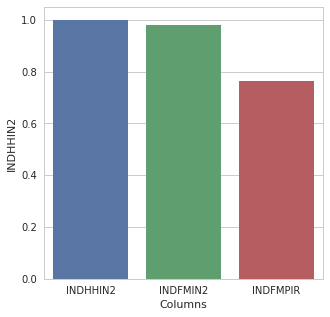

In [13]:
corrMatt = pd.DataFrame(demo_df.corr()['INDHHIN2'][:])
corrMatt['Columns'] = corrMatt.index
corrMatt = corrMatt[corrMatt['INDHHIN2']>0.5]
fig,ax= plt.subplots()
fig.set_size_inches(5,5)
sns.barplot(data=corrMatt,x='Columns',y='INDHHIN2',ax=ax,orient="v")

In [14]:
demo_df.drop(columns=['INDFMPIR','INDFMIN2'],inplace=True)

    ** As we can observe that these 2 columns have high corelation with Target *INDHHIN2* variable:
    All these columns will be removed from analysis and model building :
    
     a. INDFMPIR ‑ Ratio of family income to poverty
     b. INDFMIN2 ‑ Annual family income

### Missing [Null] Value Check and Treatment

*****************************************
 Overall Non-Missing values per columns:
*****************************************


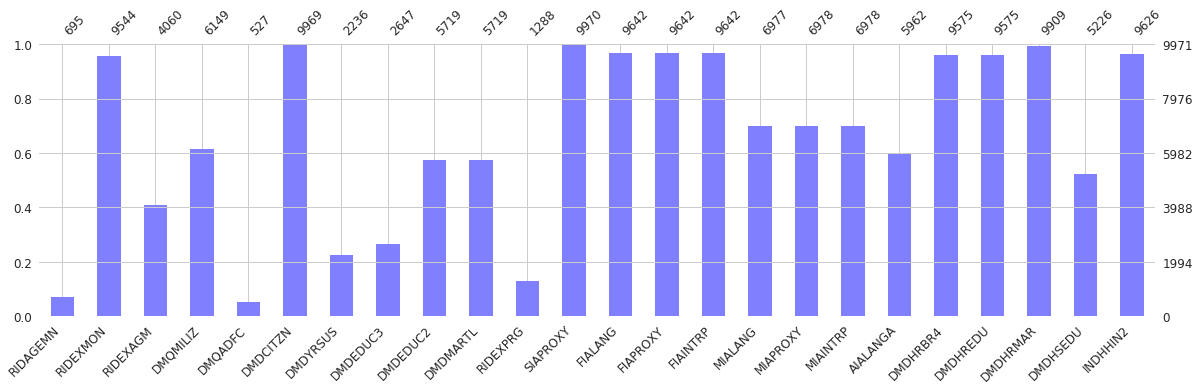

In [15]:
print("*****************************************\n Overall Non-Missing values per columns:\n*****************************************")
missingValueColumns = demo_df.columns[demo_df.isnull().any()].tolist()
msno.bar(demo_df[missingValueColumns],\
            figsize=(20,5),color=(0.5, 0.5, 1),fontsize=12,labels=True,)

#### Missing value in Target - INDHHIN2

      **As we could see there are missing values prsent in the traget and post analsyis couldnot find any external sourcs to impute the same . So I am deleting the same records from analysis.

In [16]:
demo_df = demo_df[demo_df["INDHHIN2"].isnull()==False].copy()

### % MIssing > 80%

In [17]:
print("*****************************************\n Columns having Missing values >80%:\n*****************************************")
np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x : x>80).apply(lambda x : str(x)+"%")

*****************************************
 Columns having Missing values >80%:
*****************************************


RIDAGEMN    93.0%
DMQADFC     95.0%
RIDEXPRG    87.0%
dtype: object

    ** As we can observe that these three columns have missing value % > 80%
    For all these columns the following treatment logic will be used :
    
     a. RIDAGEMN(Age in months at screening 0to24 mos):will have a boolean indicator for missing/not
     b. DMQADFC(Served in a foreign country):will have a boolean indicator for missing/not
     c. RIDEXPRG(Pregnancy status at exam):will substitue missing with a separate class

In [18]:
demo_df['is_RIDAGEMN_Present'] = np.where(demo_df.RIDAGEMN.isnull()==True,0,1).copy()
demo_df['is_DMQADFC_Present'] = np.where(demo_df.DMQADFC.isnull()==True,0,1).copy()
demo_df['RIDEXPRG'] = np.where(demo_df.RIDEXPRG.isnull()==True,-999,demo_df.RIDEXPRG)

#remove 'RIDAGEMN','DMQADFC' as treated as separate indicator columns
demo_df.drop(columns=['RIDAGEMN','DMQADFC'],inplace=True)

### % Missing < 80

In [19]:
print("*****************************************\n Columns having Missing values < 80%:\n*****************************************")
np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x : x<80).apply(lambda x : str(x)+"%")

*****************************************
 Columns having Missing values < 80%:
*****************************************


SEQN                    0.0%
RIAGENDR                0.0%
RIDAGEYR                0.0%
RIDRETH1                0.0%
RIDRETH3                0.0%
RIDEXMON                4.0%
RIDEXAGM               59.0%
DMQMILIZ               39.0%
DMDBORN4                0.0%
DMDCITZN                0.0%
DMDYRSUS               78.0%
DMDEDUC3               73.0%
DMDEDUC2               43.0%
DMDMARTL               43.0%
RIDEXPRG                0.0%
SIALANG                 0.0%
SIAPROXY                0.0%
FIALANG                 0.0%
FIAPROXY                0.0%
FIAINTRP                0.0%
MIALANG                30.0%
MIAPROXY               30.0%
MIAINTRP               30.0%
AIALANGA               40.0%
DMDHHSIZ                0.0%
DMDFMSIZ                0.0%
DMDHHSZA                0.0%
DMDHHSZB                0.0%
DMDHHSZE                0.0%
DMDHRGND                0.0%
DMDHRAGE                0.0%
DMDHRBR4                3.0%
DMDHREDU                3.0%
DMDHRMAR                1.0%
DMDHSEDU      

     ** For columns which have < 5% of missing in columns will drop those records   

### Treatment of variables having missing values < 5%  

In [20]:
print("*****************************************\n Columns having Missing values < 5%:\n*****************************************")
np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x :  (x<=5)&(x>0)).apply(lambda x : str(x)+"%")

*****************************************
 Columns having Missing values < 5%:
*****************************************


RIDEXMON    4.0%
DMDHRBR4    3.0%
DMDHREDU    3.0%
DMDHRMAR    1.0%
dtype: object

In [21]:
missing5_cols = np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x : x<=5).index

for col in missing5_cols:
    demo_df = demo_df[demo_df[col].isnull()==False].copy()
    
print("*****************************************\n Columns having Missing values < 5%:\n*****************************************")
np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x :  (x<=5)&(x>0)).apply(lambda x : str(x)+"%")

*****************************************
 Columns having Missing values < 5%:
*****************************************


Series([], dtype: float64)

#### Based on RIDEXAGM

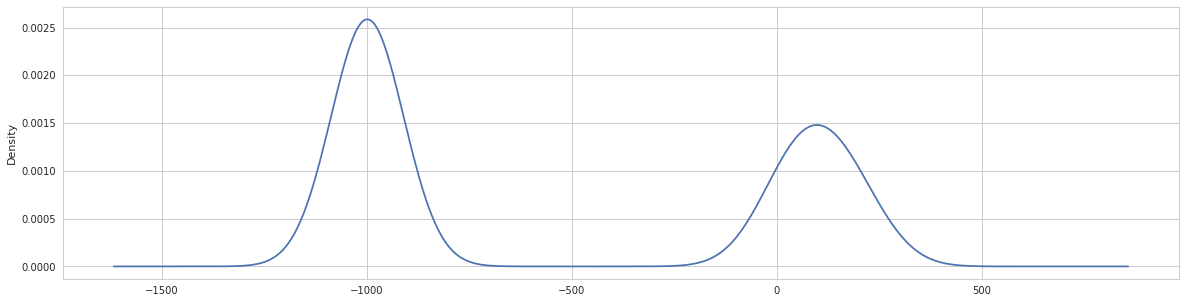

In [22]:
demo_df.RIDEXAGM.fillna(-999).plot(kind='kde',figsize=(20,5))

    ** As we can observe 57% of the records have missing value which can have specific meaning asociated to it. For instance, it may be the case the participant
    at the time of examination is older than 19 yrs hence, we have so many missing values

In [23]:
demo_df[demo_df.RIDAGEYR > 19.0].RIDAGEYR.shape

(5141,)

    ** Thus, the above number can throw some light on my hypothesis. Which leads me to impute the missing values as "-999" for the **RIDEXAGM** column

In [24]:
demo_df['RIDEXAGM'] = np.where(demo_df.RIDEXAGM.isnull()==True,-999,demo_df.RIDEXAGM).copy()

    ** Based on the manual review of the rest of the columns it seems that keeping the missing values as a separate column will make sense for the further calculation as these columns have some lift with respect to the target class. The missing value is spread across all the target class categories.

In [25]:
pd.crosstab(demo_df.DMDEDUC2.fillna(-999),demo_df.INDHHIN2)[:0]

INDHHIN2,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,13.0,14.0,15.0,77.0,99.0
DMDEDUC2,,,,,,,,,,,,,,,,
-999.0,117,143,177,232,263,401,407,306,270,202,84,52,374,675,84,38


In [26]:
missing_cat_cols = np.round((demo_df.isnull().sum()/demo_df.shape[0])*100).compress(lambda x : (x<80)&(x>0)).apply(lambda x : str(x)+"%").index
print("********************************************************\n Columns list which will be imputed with new value[-999] : \n********************************************************\n",
      missing_cat_cols.values)

********************************************************
 Columns list which will be imputed with new value[-999] : 
********************************************************
 ['DMQMILIZ' 'DMDYRSUS' 'DMDEDUC3' 'DMDEDUC2' 'DMDMARTL' 'MIALANG'
 'MIAPROXY' 'MIAINTRP' 'AIALANGA' 'DMDHSEDU']


In [27]:
for col in missing_cat_cols:
    demo_df[col] = np.where(demo_df[col].isnull()==True,-999,demo_df[col])

#### Assign datatype INT to INT-columns having FLOAT datatype

In [28]:
for c in demo_df.columns:
    if(np.array_equal(demo_df[c].round(7), demo_df[c].astype(int))==True):
        demo_df[c] = demo_df[c].astype(int) 

In [29]:
print("Varibale types and count:\n******************************\n", 
      pd.DataFrame(demo_df.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"}))

Varibale types and count:
******************************
   variableType  count
0        int64     40
1      float64      2


In [30]:
print("demo_df shape: #rows, #columns :-",demo_df.shape)

demo_df shape: #rows, #columns :- (8966, 42)


In [31]:
demo_df.to_csv("demo_df.csv",index=False)

In [32]:
demo_df = pd.read_csv("./demo_df.csv")

# Train-Test Split

    `** Post pre-processing is done we will split the dataframe into train and test 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(demo_df.drop(columns=['INDHHIN2','SEQN']), demo_df.INDHHIN2, stratify=demo_df.INDHHIN2,
                                                    test_size=0.2,
                                                    random_state=9)

In [34]:
print("train df shape :-",X_train.shape)
print("test df shape :-",X_test.shape)

train df shape :- (7172, 40)
test df shape :- (1794, 40)


In [35]:
print("train target shape :-",y_train.shape)
print("test target shape :-",y_test.shape)

train target shape :- (7172,)
test target shape :- (1794,)


# Exploratory Data Analysis

***********************************************

    ** For EDA purpose will merge the target column to the train-df 

In [36]:
data = pd.concat([X_train,y_train],axis=1,copy=True,ignore_index=False)

    ** Based on the general understanding my hypothesis is the "house-hold income" will be depended on the education level, family size, also on the individual
    family income as if the higher the Family income and more than one family resides in a house-hold the "house-hold income" is bound to be associated to it.
    Variables assocaited with information on Citizanship or Birth country will also be of great essence as they are more likely to have some stable source of income, same for participant's served for the nation will during war or some sorts of Foregin Land Service.  

    ** I would like to check the linear correlation/PPSCORE between the target variable and features to authenticate my hypothesis and check if thought experiment works or not. 

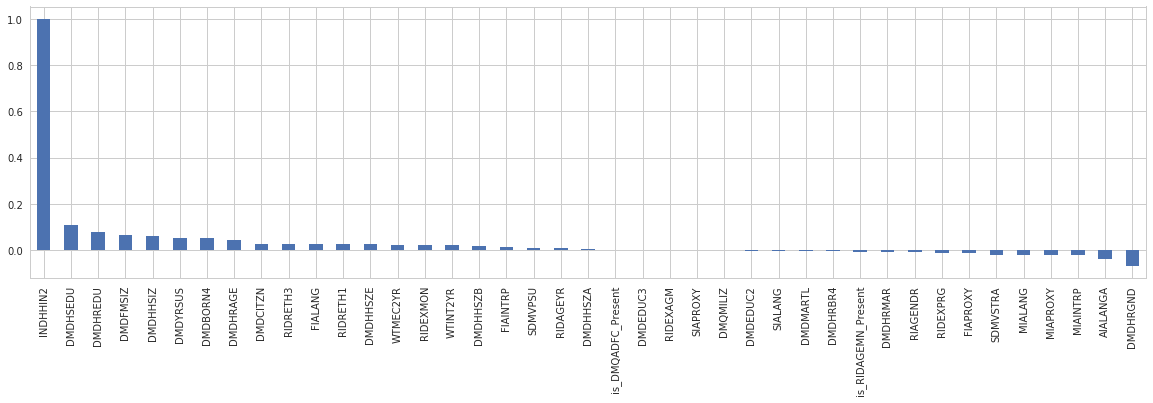

In [37]:
data.apply(lambda x : x.corr(data.INDHHIN2)).sort_values(ascending=False).plot(kind='bar',figsize=(20,5))

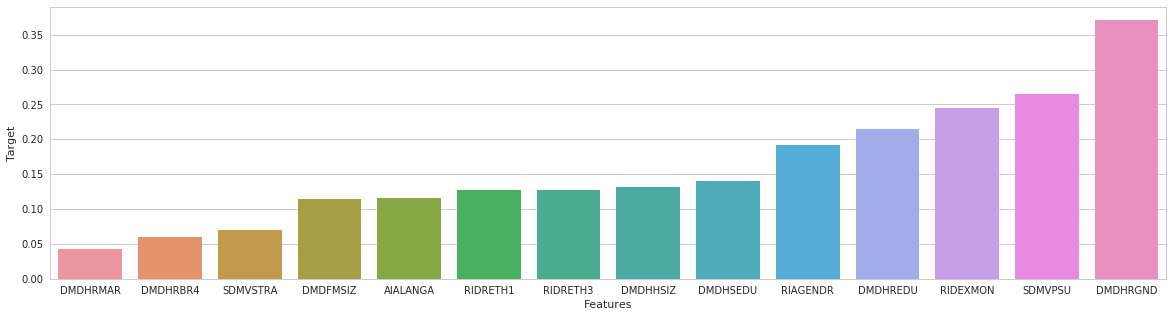

In [38]:
pred_df=X_train.copy()

pred_df['Target'] = y_train.apply(str)
pred_df_mat  = pps.matrix(pred_df)
pred_df_mat1 = pd.DataFrame(pred_df_mat['Target'])
pred_df_mat1['Features'] = pred_df_mat.index
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=pred_df_mat1[(pred_df_mat1['Target']>0.01) & (pred_df_mat1['Features']!='Target')].sort_values('Target'),x='Features',y='Target',ax=ax,orient="v")

    ** Simmillar to correlation , have used predictive score for each feature to verify if the features have predictive power with respect to Target variable.We could see the fetaures like DMDHRGND,RIDEXMON,SDMVPSU etc. are having good predictive power.
    
    The PPS is an score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). It can be used as an alternative to the correlation (matrix).

    ** Looking at the results it does makes sense for these variables to have +ve correlation with the target

## Feature Analysis (As recived from PPScore) : Top 5 Features

***************
 Feature Names 
***************
 
Target Feature :  INDHHIN2
Independent Feature :  DMDHRGND
mode:  0    15
dtype: int64


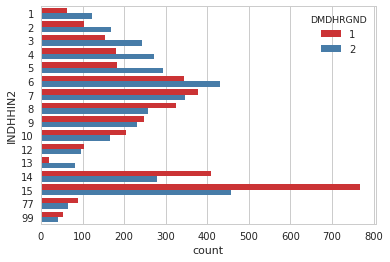

In [39]:
categorical_summarized(data, y = 'INDHHIN2', hue='DMDHRGND')

     ** As we could see from above at the lower side of houseincome groups ,representation of HH-female are higher, While we go more on the higher side HH-male represent more.

***************
 Feature Names 
***************
 
Target Feature :  INDHHIN2
Independent Feature :  SDMVPSU
mode:  0    15
dtype: int64


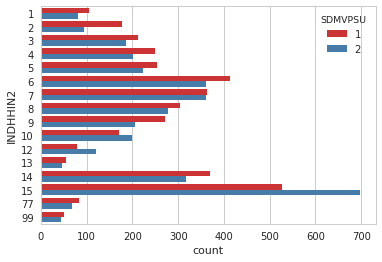

In [40]:
categorical_summarized(data, y = 'INDHHIN2', hue='SDMVPSU')

***************
 Feature Names 
***************
 
Target Feature :  INDHHIN2
Independent Feature :  RIDEXMON
mode:  0    15
dtype: int64


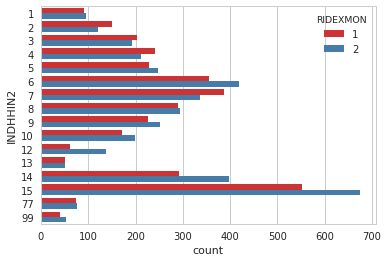

In [41]:
categorical_summarized(data, y = 'INDHHIN2', hue='RIDEXMON')

        ** As we could see from above at the the first half of the examination could had been performed at low group income first and then second haf on the examination is performed with higher income groups.This is really intresting.

***************
 Feature Names 
***************
 
Target Feature :  INDHHIN2
Independent Feature :  DMDHREDU
mode:  0    15
dtype: int64


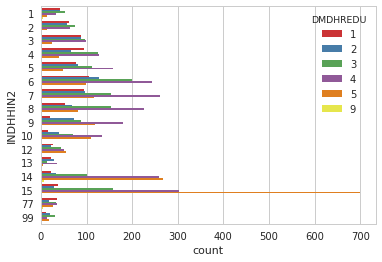

In [42]:
categorical_summarized(data, y = 'INDHHIN2', hue='DMDHREDU')

    ** we can observe the higher the education/Don't know of records are for higher income bracket. 1st 3 level of education groupd dominate the lower income group and middle education groups domiate the middle income groups.

***************
 Feature Names 
***************
 
Target Feature :  INDHHIN2
Independent Feature :  DMDHSEDU
mode:  0    15
dtype: int64


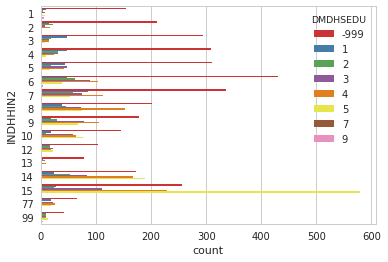

In [43]:
categorical_summarized(data, y = 'INDHHIN2', hue='DMDHSEDU')

    ** we can observe the higher the education/Don't know of records are for higher middle/higher income bracket. 1st few level of education groups dominate the lower income groups and middle education groups domiate the middle income groups.

    ** It seems these features which have high correlation/PPScore with the target are mostly driven based on the information we have on the house-hold reference person  or to express in terms of simpleton i.e. one who owns the house-hold.

# Feature Engineering & selection

*****************************************

    ** I have created 2 datasets here:
    
     1. First one is based on taking all the features that we are creatinga and performing corelation filter analysis
     
     2. Second one is more to do with some functional analysis and applying some common domain knowledge based feature selection and general understanding.

### Data Set - 1 : Based on statical selection on all data

In [44]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()

#### 2nd-order Polynomial Feature Engineering

In [45]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
poly.fit(X_train)
poly_X = pd.DataFrame(poly.transform(X_train),columns=poly.get_feature_names(X_train.columns))

In [46]:
poly_X.apply(lambda x:x.corr(y_train)).sort_values(ascending = False)[:10]

RIAGENDR DMDHRMAR    0.042846
SIALANG DMDHRMAR     0.040433
DMDHRGND DMDHRMAR    0.032879
DMDFMSIZ DMDHRMAR    0.031537
DMDHRMAR SDMVSTRA    0.031511
FIAPROXY DMDHRMAR    0.031105
DMDHRMAR             0.031077
DMDEDUC3 DMDHHSZB    0.030579
DMDHHSIZ DMDHRMAR    0.030518
DMDHRAGE DMDHRMAR    0.029554
dtype: float64

    ** In Above have created Interaction/polynomial(2nd order) features for adding in to data based upon checking the corr. value with target.Have chosen top 2 features based on corr value.

In [47]:
X_train1['DMDHHSZA*is_DMQADFC_Present'] = X_train.DMDHHSZA * X_train.is_DMQADFC_Present
X_train1['DMQMILIZ*DMDHHSZA'] = X_train.DMQMILIZ * X_train.DMDHHSZA

In [48]:
X_test1['DMDHHSZA*is_DMQADFC_Present'] = X_test.DMDHHSZA * X_test.is_DMQADFC_Present
X_test1['DMQMILIZ*DMDHHSZA'] = X_test.DMQMILIZ * X_test.DMDHHSZA

#### Feature Selection for Datset:-1, using corr filter

In [49]:
corr_matrix = X_train.loc[:, ~X_train.columns.isin(['tag'])].corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

print("No of features to drp based on corr filter-",len(to_drop))

No of features to drp based on corr filter- 12


In [50]:
X_train1.drop(columns=to_drop,inplace=True)
X_test1.drop(columns=to_drop,inplace=True)

#### Feature Selection for Datset:-1, using PPScore

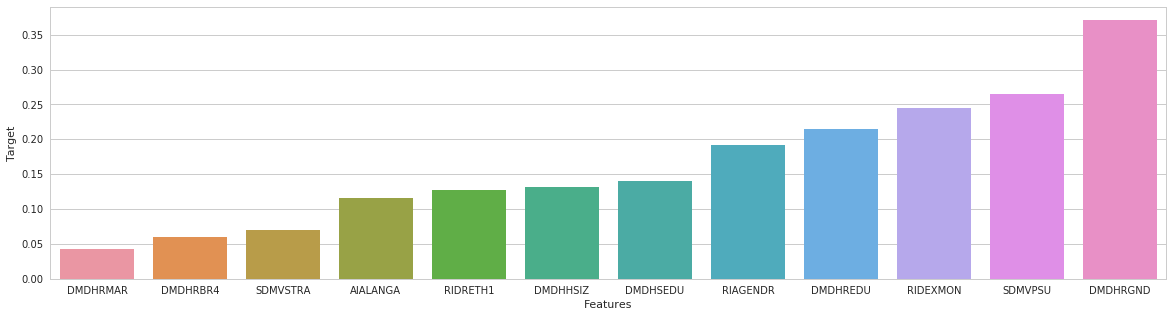

In [51]:
pred_df=X_train1.copy()

pred_df['Target'] = y_train.apply(str)
pred_df_mat  = pps.matrix(pred_df)
pred_df_mat1 = pd.DataFrame(pred_df_mat['Target'])
pred_df_mat1['Features'] = pred_df_mat.index
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=pred_df_mat1[(pred_df_mat1['Target']>0.01) & (pred_df_mat1['Features']!='Target')].sort_values('Target'),x='Features',y='Target',ax=ax,orient="v")

In [52]:
pps_cols = pred_df_mat1[(pred_df_mat1['Target']>0.01) & (pred_df_mat1['Features']!='Target')].Features.values
print("***********************************\nBased on PPScore below features are selected\n***********************************\n:\n",pps_cols)

***********************************
Based on PPScore below features are selected
***********************************
:
 ['RIAGENDR' 'RIDRETH1' 'RIDEXMON' 'AIALANGA' 'DMDHHSIZ' 'DMDHRGND'
 'DMDHRBR4' 'DMDHREDU' 'DMDHRMAR' 'DMDHSEDU' 'SDMVPSU' 'SDMVSTRA']


In [53]:
X_train1 = X_train1[pps_cols]
X_test1 = X_test1[pps_cols]

In [54]:
print("Train:1 shape: #rows, #columns :-",X_train1.shape)
print("Test:1 shape: #rows, #columns :-",X_test1.shape)

Train:1 shape: #rows, #columns :- (7172, 12)
Test:1 shape: #rows, #columns :- (1794, 12)


    ** Performed Corrleation analysis and selected reduced set of fetaures which are having greater than 80% corr value.

### Data Set - 2 : Based on Data Understanding

    ** Intuition behind the features selected.
    The thought process behind the selection was to isolate the attributes which will have high contribution for determining the HH income. So, based on the
    understing the attributes directly associated to the HH reference person will have high correlation. For instance the HH ref person's age, gender , education
    level her/hers spouse education level, country of birth and citizanship etc.
    
    Thus, I decided to selcet these columns.
    Post preliminary analysis it seem the presence of missing values in few columns are having higher percentage then the rest of the category so, I decided
    to consider a new feature stating the boolean value for the indicating the presence of missing value or not.
    
    ** For DMQADFC columns the hypothesis was the vetreains might have some financial stablity.
    ** For RIDAGEMN columns missing column to indicate the presence of child in the house-hold.

In [55]:
demo_df.is_RIDAGEMN_Present.value_counts(normalize=True)

0    0.9294
1    0.0706
Name: is_RIDAGEMN_Present, dtype: float64

In [56]:
random_state = 9

In [57]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

In [58]:
X_train2['DMDHSEDU_missing'] = np.where(X_train.DMDHSEDU==-999.0,1,0)
X_test2['DMDHSEDU_missing'] = np.where(X_test.DMDHSEDU==-999.0,1,0)

In [59]:
s_col = list(set(['DMDHHSIZ','DMDHHSZA','DMDHHSZB','DMDHHSZE','DMDHRGND','DMDHRBR4','DMDHREDU','DMDHRMAR',
       'DMDHSEDU','DMDHSEDU_missing','is_RIDAGEMN_Present','is_DMQADFC_Present','RIDRETH1',
        'DMDHRAGE'
      ]))

In [60]:
X_train2 = X_train2[s_col]
X_test2 = X_test2[s_col]

#### Feature Selection for Datset:-2

In [61]:
corr_matrix = X_train2.loc[:, ~X_train2.columns.isin(['tag'])].corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
len(to_drop)

1

In [62]:
X_train2.drop(columns=to_drop,inplace=True)
X_test2.drop(columns=to_drop,inplace=True)

In [63]:
print("Train:2 shape: #rows, #columns :-",X_train2.shape)
print("Test:2 shape: #rows, #columns :-",X_test2.shape)

Train:2 shape: #rows, #columns :- (7172, 13)
Test:2 shape: #rows, #columns :- (1794, 13)


# Model Building

*******************************************

#### Spot Check with 3 classification Algorithm
  1. Logistics Regression (Linear Algorithm)
  2. Random Forest Classification (Tree Based Bagging Algorithm)
  2. LightGBM Classification (Tree Based Boosting Algorithm)

In [64]:
kfold = StratifiedKFold(n_splits=5)
random_state = 9

In [65]:
classifiers = []

classifiers.append(LogisticRegression(solver='newton-cg',multi_class='ovr',random_state = random_state))
classifiers.append(RandomForestClassifier(random_state=random_state,max_depth=15,))
classifiers.append(lgb.LGBMClassifier(objective='multiclassova',
                                      metric="multi_logloss",
                                      num_class= 16,
                                      num_leaves =30,
                                      max_depth =15,
                                      bagging_fraction = 0.7,
                                      feature_fraction = 0.7,
                                      bagging_frequecy = 5,
                                      bagging_seed = 2020,
                                      random_state=random_state))          

### Spot-Checking with DataSet:-1

In [66]:
X_train = X_train1
X_test = X_test1

In [67]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier, X_train, y = y_train, scoring = ["balanced_accuracy","accuracy","f1_weighted"], cv = kfold, n_jobs=-1))

cv_means_accuracy_means = []
cv_means_balanced_accuracy_means = []
cv_means_f1_weighted_means = []
cv_means_accuracy_std = []
cv_means_balanced_accuracy_std = []
cv_means_f1_weighted_std = []

for cv_result in cv_results:
    cv_means_balanced_accuracy_means.append(cv_result['test_balanced_accuracy'].mean())
    cv_means_balanced_accuracy_std.append(cv_result['test_balanced_accuracy'].std())
    cv_means_accuracy_means.append(cv_result['test_accuracy'].mean())
    cv_means_accuracy_std.append(cv_result['test_accuracy'].std())
    cv_means_f1_weighted_means.append(cv_result['test_f1_weighted'].mean())
    cv_means_f1_weighted_std.append(cv_result['test_f1_weighted'].std())

cv_res = pd.DataFrame({"CVMeans_Acc":cv_means_accuracy_means,"CVerrors_Acc": cv_means_accuracy_std ,
                       "CVMeans_BalAcc":cv_means_balanced_accuracy_means,"CVerrors_BalAcc": cv_means_balanced_accuracy_std ,
                       "CVMeans_F1-wtd":cv_means_f1_weighted_means,"CVerrors_F1-wtd": cv_means_f1_weighted_std 
                       ,"Algorithm":["LogisticRegression","RandomForest","LightGBM"]})

print("*********************************\nResult from Spot Check Modeling with Data-1\n*********************************\n")
cv_res

*********************************
Result from Spot Check Modeling with Data-1
*********************************



,CVMeans_Acc,CVerrors_Acc,CVMeans_BalAcc,CVerrors_BalAcc,CVMeans_F1-wtd,CVerrors_F1-wtd,Algorithm
0,0.223801,0.006648,0.109032,0.004605,0.144007,0.005479,LogisticRegression
1,0.565848,0.011509,0.524550,0.008650,0.563782,0.010654,RandomForest
2,0.536962,0.016315,0.504250,0.016586,0.532712,0.017087,LightGBM


        ** From the result above, 

    1. Logitics regression perform poorly
    2. All 3 scores from RF are good but the varinace is high compared LR and LGBM
    3. we could see cv. balanced accuracy for LightGBM is highest with less error/std dev. compared to RF.
    

### Model Spot-Checking with DataSet:-2

In [68]:
X_train = X_train2
X_test = X_test2

In [69]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier, X_train, y = y_train, scoring = ["balanced_accuracy","accuracy","f1_weighted"], cv = kfold, n_jobs=-1))

# cv_means = []
# cv_std = []
# for cv_result in cv_results:
#     cv_means.append(cv_result.mean())
#     cv_std.append(cv_result.std())

cv_means_accuracy_means = []
cv_means_balanced_accuracy_means = []
cv_means_f1_weighted_means = []
cv_means_accuracy_std = []
cv_means_balanced_accuracy_std = []
cv_means_f1_weighted_std = []

for cv_result in cv_results:
    cv_means_balanced_accuracy_means.append(cv_result['test_balanced_accuracy'].mean())
    cv_means_balanced_accuracy_std.append(cv_result['test_balanced_accuracy'].std())
    cv_means_accuracy_means.append(cv_result['test_accuracy'].mean())
    cv_means_accuracy_std.append(cv_result['test_accuracy'].std())
    cv_means_f1_weighted_means.append(cv_result['test_f1_weighted'].mean())
    cv_means_f1_weighted_std.append(cv_result['test_f1_weighted'].std())

cv_res = pd.DataFrame({"CVMeans_Acc":cv_means_accuracy_means,"CVerrors_Acc": cv_means_accuracy_std ,
                       "CVMeans_BalAcc":cv_means_balanced_accuracy_means,"CVerrors_BalAcc": cv_means_balanced_accuracy_std ,
                       "CVMeans_F1-wtd":cv_means_f1_weighted_means,"CVerrors_F1-wtd": cv_means_f1_weighted_std 
                       ,"Algorithm":["LogisticRegression","RandomForest","LightGBM"]})

print("*********************************\nResult from Spot Check Modeling with Data-2\n*********************************\n")
cv_res

*********************************
Result from Spot Check Modeling with Data-2
*********************************



,CVMeans_Acc,CVerrors_Acc,CVMeans_BalAcc,CVerrors_BalAcc,CVMeans_F1-wtd,CVerrors_F1-wtd,Algorithm
0,0.229066,0.007370,0.117424,0.007743,0.160296,0.008577,LogisticRegression
1,0.654207,0.010185,0.625981,0.013875,0.653154,0.010172,RandomForest
2,0.604828,0.009514,0.589928,0.015585,0.601853,0.009177,LightGBM


        ** From the result above, we could see cv. balanced accuracy/accuracy/weigted F1 for LightGBM is little less than RF but error/std dev. compared to Random Forest is quite less.

        Also with Dataset:1 also, we have seen LightGBM having less avg. cv error as well for RF.

            So I proceed ahead with LGBM & Dataset-2, we could take LightGBM with Dataset-2 for further processing .(Hyperparatmet tuning , final model building)

#### Hyper Parameter Tuning ###

***********************************************************

    ** For hyperparameter tuning , i have taken bayseian optimization approach with Hyperopt library. As from experince this works pretty fast compared to Grid-search or Random-search.Also it converges fast and tries to avoid local minima better compared to above method.LightGBM have quite a number of hyperparameters that overlap in their purpose.
    
    There are mainly 6 hyper-parameters , i am concentrating on, as metioned below:
       1. num_leaves - number of leaves to try out in each tree , this is interrelated to max_depth
       2. max_depth -  max depth to try out in each tree heirarchy
       3. bagging_frequecy - Bagging to be performed after this frequency of iteartion
       4. bagging_fraction - After chnage of each bagging frequency bagging fraction is changed based this no.
       5. feature_fraction - will randomly select fraction of features on each iteration
       6. learning_rate -determin-es the step size at each iteration while moving toward a minimum of a loss function,learning_rate parameter can be set to control the weighting of new trees added to the model.
       7. lambda_l1 - L1 regularization in GBDTs is applied to leaf scores 

    ** For hyperparameter tuning , the objective scoring used is : Balanced accuracy is a metric that one can use when evaluating how good a multiclass classifier is. It is especially useful when the classes are imbalanced. The loss functin that is used is, multilogg_loss which is multi class cross entropy function

In [70]:
## Hyper Parameter Optzn. Space creation
#############################################3

def objective(params):
    params = {
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'bagging_frequecy': int(params['bagging_frequecy']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'learning_rate': '{:.3f}'.format(params['learning_rate']),
        'lambda_l1' : '{:.3f}'.format(params['lambda_l1'])
    }
    
    clf = lgb.LGBMClassifier(
        random_state=random_state,
        objective='multiclassova',
        metric="multi_logloss",
        num_class= 16,
        bagging_seed=2020,
        **params
    )
    
    score = cross_val_score(clf, X_train, y_train, scoring = "f1_weighted", cv = kfold, n_jobs=-1).mean()
#     print("balanced_accuracy {:.3f} params {}".format(score, params))
    return -score

space = {
    'num_leaves': hp.quniform('num_leaves', 5, 50, 2),
    'max_depth': hp.quniform('max_depth', 5, 25, 2),
    'bagging_frequecy': hp.quniform('bagging_frequecy', 1,20,2),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1.0),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.5),
    'lambda_l1': hp.uniform('lambda_l1', 0, 5)
}


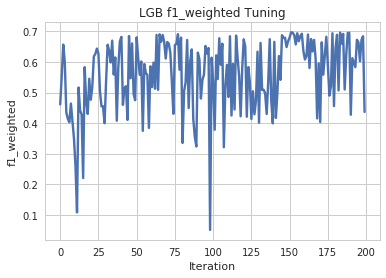

**********************
 Best HyperParameters 
**********************

{'bagging_fraction': 0.41176281606868137, 'bagging_frequecy': 2.0, 'feature_fraction': 0.6580614161626499, 'lambda_l1': 0.21790236962967968, 'learning_rate': 0.3234050344812117, 'max_depth': 16.0, 'num_leaves': 46.0}

 **Best F1 Weighted Score on CV data: 0.6968005317084622


In [71]:
## Hyper Parameter Optzn.
#############################################3

tpe_trials = Trials()

best_hyp = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=200,
            trials=tpe_trials,verbose=False,rstate= np.random.RandomState(random_state))

trial=pd.DataFrame(tpe_trials.results)
trial['Iteration'] = trial.index
plt.plot(trial['Iteration'],trial['loss']*-1 , linewidth=2.4)
plt.xlabel('Iteration')
plt.ylabel('f1_weighted')
plt.title('LGB f1_weighted Tuning')
plt.grid(True)
plt.show()

print("**********************\n Best HyperParameters \n**********************\n")
print(best_hyp)
print("\n **Best F1 Weighted Score on CV data:",max(trial['loss']*-1))

    ** As we can see, the best score with 200 itertaion of optimization forhyper parameter tuning is: we got a  
    F1 Weighted : 
    
    Taking the best hyper parameter , we train the final model with cross validation.
            


In [78]:
## Building Final model with LGBM classifier
## *********************************************

clf = lgb.LGBMClassifier(
        random_state=random_state,
        learning_rate='{:.3f}'.format(best_hyp['learning_rate']),
        objective='multiclassova',
        metric="multi_logloss",
        num_class= 16,
        bagging_seed=2020,
        num_leaves =int(best_hyp['num_leaves']),
        max_depth =int(best_hyp['max_depth']),
        bagging_fraction = '{:.3f}'.format(best_hyp['bagging_fraction']),
        feature_fraction = '{:.3f}'.format(best_hyp['feature_fraction']),
        bagging_frequecy = int(best_hyp['bagging_frequecy']),
        n_jobs=-1
    )

## Find diffrent scores on diffrent datasets:- Train , Cross Validation , Test
clf.fit(X_train, y_train)

accuracy = []
balanced_accuracy = []
f1_weighted = []

balanced_accuracy.append(metrics.balanced_accuracy_score(y_train,clf.predict(X_train)))
accuracy.append(metrics.accuracy_score(y_train,clf.predict(X_train)))
f1_weighted.append(metrics.f1_score(y_train,clf.predict(X_train),average='weighted'))

balanced_accuracy.append(cross_val_score(clf, X_train, y_train, scoring = "accuracy", cv = kfold, n_jobs=-1).mean())
accuracy.append(cross_val_score(clf, X_train, y_train, scoring = "balanced_accuracy", cv = kfold, n_jobs=-1).mean())
f1_weighted.append(cross_val_score(clf, X_train, y_train, scoring = "f1_weighted", cv = kfold, n_jobs=-1).mean())

## Predict on Test Data and get scores:

balanced_accuracy.append(metrics.balanced_accuracy_score(y_test,clf.predict(X_test)))
accuracy.append(metrics.accuracy_score(y_test,clf.predict(X_test)))
f1_weighted.append(metrics.f1_score(y_test,clf.predict(X_test),average='weighted'))

    
Score_Result = pd.DataFrame({"balanced_accuracy":balanced_accuracy,
                       "accuracy":accuracy,
                       "f1_weighted":f1_weighted
                       ,"Scores":["Train Data","CVal Data","Test Data"]})

print("**********************\n Score result on final model \n**********************\n")
print(Score_Result)

**********************
 Score result on final model 
**********************

   balanced_accuracy  accuracy  f1_weighted      Scores
0           0.962978  0.960262     0.960268  Train Data
1           0.699787  0.672865     0.698815   CVal Data
2           0.683738  0.716834     0.716249   Test Data


            ** As we can see from above Classification table:-
            The blalanced accuracy, accuracy and F1-weighted scores are very near for Cross Val Data (5 fold) and test data. Infact oaverall score is higher in test, compared to cross val data and this can be reduced if go for more no of cross validation. The train score is higher but it couldn't get reduced even with multiple iterations of hyper paramater tuning.

    

In [79]:
target_names = list(y_train.unique())
y_pred = pd.Series(clf.predict(X_test))
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.68      0.65      0.67        46
           2       0.72      0.60      0.66        68
           3       0.63      0.66      0.65       100
           4       0.73      0.73      0.73       113
           5       0.70      0.65      0.67       119
           6       0.62      0.75      0.68       194
           7       0.77      0.76      0.77       181
           8       0.76      0.68      0.71       146
           9       0.79      0.68      0.73       120
          10       0.73      0.67      0.70        92
          12       0.75      0.60      0.67        50
          13       0.82      0.69      0.75        26
          14       0.68      0.72      0.70       172
          15       0.74      0.83      0.78       306
          77       0.82      0.71      0.76        38
          99       0.76      0.57      0.65        23

   micro avg       0.72      0.72      0.72      1794
   macro avg       0.73   

    ** As we can see from above Classification table ,
    1.Prediction for class -15 ($100,000 and Over) is highest as its directly identifiable from eduction and age. 
    
    2.Simmilarly Classes - 99 , 3 are lowest in terms pf test prediction . Class 99 is lowest as it's "Dont Know". 
    
    3.Rest other classes are on an avg , having scores around 0.7 .

        

# Feature Importance

In [80]:
feature_imp = pd.DataFrame({'Value':clf.feature_importances_,'Feature':X_test.columns})
feature_imp = feature_imp.sort_values(by="Value", ascending=False).copy()

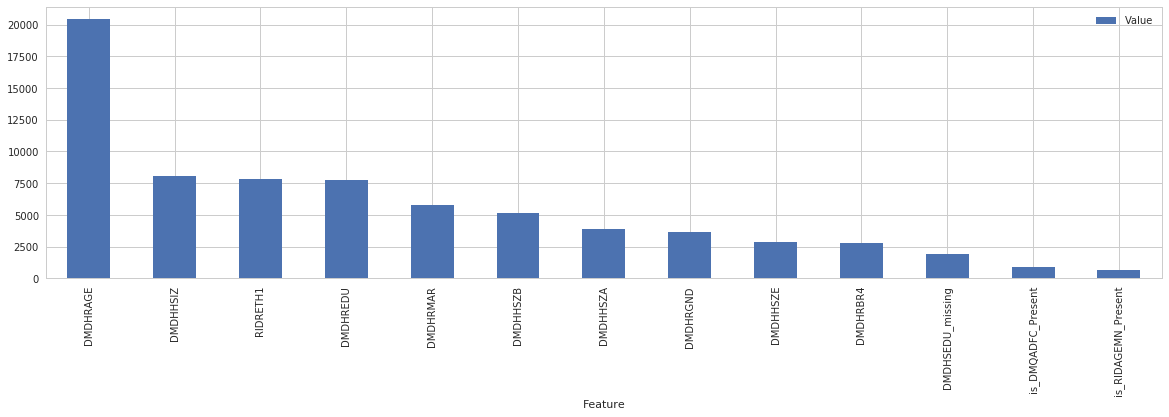

In [81]:
feature_imp.Value = feature_imp.Value.astype(float)
feature_imp[:50].plot.bar(x="Feature", y="Value", figsize=(20, 5))

    ** Thus, we can see the HH ref person's age seems to be the most import feature for predicting the HH income and intuitively it makes sense.
    Attributes like Education,race and house-size also makes important contribution for the model to bifurcate the House Hold income bands
    
    1.DMDHRAGE ‑ HH ref person's age in years
    2.DMDHREDU ‑ HH ref person's education level
    3.DMDHHSIZ ‑ Total number of people in the Household
    4.RIDRETH1 ‑ Race/Hispanic origin
    5.DMDHRMAR ‑ HH ref person's marital status